# Making a pytorch dataset from Wireless ECoG data
Michael Nolan
2020.07.08

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import json
import pickle as pkl
# from skimage import io, transform
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# plt.ion()   # interactive mode


In [39]:
class WirelessEcogDataset(Dataset):
    # Wireless ECoG Dataset
    # Pesaran lab data
    # AOLab
    # Michael Nolan
    # 2020.07.08
    
    def __init__( self, ecog_file, src_len, trg_len, step_len, ch_idx = None):
        ## parse file
        data_file = os.path.basename(ecog_file)
        data_file_kern = os.path.splitext(data_file)[0]
        rec_id, microdrive_name, rec_type = data_file_kern.split('.')
        data_path = os.path.dirname(ecog_file)
        # read experiment file
        exp_file = os.path.join(data_path,rec_id + ".experiment.json")
        with open(exp_file,'r') as f:
            exp_dict = json.load(f)
        # get microdrive parameters
        microdrive_name_list = [md['name'] for md in exp_dict['hardware']['microdrive']]
        microdrive_idx = [md_idx for md_idx, md in enumerate(microdrive_name_list) if microdrive_name == md][0]
        microdrive_dict = exp_dict['hardware']['microdrive'][microdrive_idx]
        n_ch = len(microdrive_dict['electrodes'])
        if not ch_idx:
            ch_idx = np.arange(n_ch)
        # get srate
        if rec_type == 'raw':
            srate = experiment['hardware']['acquisition']['samplingrate']
            data_type = np.ushort
        elif rec_type == 'lfp':
            srate = 1000
            data_type = np.float32
        elif rec_type == 'clfp':
            srate = 1000
            data_type = np.float32
        # read mask
        ecog_mask_file = os.path.join(data_path,data_file_kern + ".mask.pkl")
        with open(ecog_mask_file,"rb") as mask_f:
            mask = pkl.load(mask_f)
        mask = mask["hf"] | mask["sat"]
        # get params
        n_samp = len(mask)
        # create sampling index - src_len+trg_len length segments that don't include a masked sample
        _sample_idx = np.arange(n_samp-(src_len+trg_len),step=step_len)
        _use_sample_idx = np.zeros((len(_sample_idx)),dtype=bool) # all false
        for sidx in range(len(_sample_idx)):
            _use_sample_idx[sidx] = ~np.any(mask[_sample_idx[sidx] + np.arange(src_len+trg_len)])
        sample_idx = _sample_idx[_use_sample_idx]
        
        ## set parameters
        self.file_path = ecog_file
        self.n_ch = n_ch
        self.ch_idx = ch_idx
        self.n_samp = n_samp
        self.sample_idx = sample_idx
        self.data_type = data_type
        self.byte_per_sample = n_ch * data_type().nbytes
        self.src_len = src_len
        self.trg_len = trg_len
        
    def __len__( self ):
        return len(self.sample_idx)
    
    def __getitem__( self, idx ):
        count = (self.src_len + self.trg_len)*self.n_ch
        offset = self.sample_idx[idx]*self.n_ch*self.data_type().nbytes
        data_sample = np.fromfile(self.file_path,dtype=self.data_type,count=count,offset=offset).reshape((self.n_ch,self.src_len+self.trg_len),order='F').T
        src, trg = np.split(data_sample[:,self.ch_idx],[self.src_len])
        
        return src, trg


In [92]:
# test it out!
src_len = 1000
trg_len = 500
step_len = 500
ecog_file = '/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.dat'

dataset = WirelessEcogDataset(ecog_file,src_len,trg_len,step_len)

/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.experiment.json


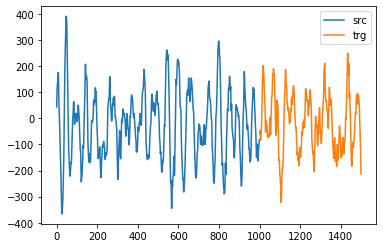

In [53]:
src,trg = dataset.__getitem__(0)
plt.plot(np.arange(dataset.src_len),src[:,0],label='src')
plt.plot(dataset.src_len + np.arange(trg_len),trg[:,0],label='trg')
plt.legend(loc=0)

it works! now let's make a dataloader + sampler for this lil bad boy:

In [78]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
train_p = 0.8
train_idx, valid_idx = np.split(dataset.sample_idx,[np.int(np.floor(train_p*dataset.__len__()))])
train_loader = DataLoader(dataset,sampler=SubsetRandomSampler(train_idx),batch_size=10,shuffle=False)
valid_loader = DataLoader(dataset,sampler=SubsetRandomSampler(valid_idx),batch_size=10,shuffle=False)

In [62]:
for bidx, (src_batch, trg_batch) in enumerate(dataloader):
    if bidx > 0:
        break

### ECoG dataloader across multiple files

In [163]:
class WirelessEcogDataset_MultiFile(Dataset):
    # Wireless ECoG Dataset
    # Pesaran lab data
    # AOLab
    # Michael Nolan
    # 2020.07.08
    
    def __init__( self, ecog_file_list, src_len, trg_len, step_len, ch_idx = None ):
        data_parameter_dict = self.create_parameter_dict(ecog_file_list,src_len,trg_len,step_len,ch_idx)
        
        ## set parameters
        self.file_list = ecog_file_list
#         self.n_ch = n_ch
#         self.ch_idx = ch_idx
#         self.n_samp = n_samp
#         self.sample_idx = sample_idx
#         self.data_type = data_type
#         self.byte_per_sample = n_ch * data_type().nbytes
        self.src_len = src_len
        self.trg_len = trg_len
        self.data_parameter_dict = data_parameter_dict
        self.file_ref_idx = np.cumsum([len(x) for x in data_parameter_dict['sample_idx']])
        self.file_offset_idx = np.zeros(self.file_ref_idx.shape,dtype=int)
        self.file_offset_idx[1:] = self.file_ref_idx[:-1]
        
    def __len__( self ):
        return sum([len(x) for x in self.data_parameter_dict['sample_idx']])
    
    def __getitem__( self, idx ):
        file_idx = np.arange(len(self.file_list))[idx < self.file_ref_idx][0]
        filepath = self.file_list[file_idx]
        in_file_sample_idx = idx - self.file_offset_idx[file_idx]
        dtype = self.data_parameter_dict['data_type'][file_idx]
        n_ch = self.data_parameter_dict['n_ch'][file_idx]
        ch_idx = self.data_parameter_dict['ch_idx'][file_idx]
        count = (self.src_len + self.trg_len)*n_ch
        offset = self.data_parameter_dict['sample_idx'][file_idx][in_file_sample_idx]*n_ch*dtype().nbytes
        data_sample = np.fromfile(filepath,dtype=dtype,count=count,offset=offset).reshape((n_ch,self.src_len+self.trg_len),order='F').T
        src, trg = np.split(data_sample[:,ch_idx],[self.src_len])
        
        return src, trg
    
    def create_parameter_dict( self, ecog_file_list, src_len, trg_len, step_len, ch_idx=None ):
        n_file = len(ecog_file_list)
        n_samp_list = []
        n_ch_list = []
        srate_list = []
        data_type_list = []
        sample_idx_list = []
        ch_idx_list = []
        for file in ecog_file_list:
            _n_samp, _n_ch, _srate, _data_type, _sample_idx, _ch_idx = self.get_ecog_file_parameters(file,src_len,trg_len,step_len,ch_idx)
            n_samp_list.append(_n_samp)
            n_ch_list.append(_n_ch)
            srate_list.append(_srate)
            data_type_list.append(_data_type)
            sample_idx_list.append(_sample_idx)
            ch_idx_list.append(_ch_idx)
        parameter_dict = {
            'n_samp': n_samp_list,
            'n_ch': n_ch_list,
            'srate': srate_list,
            'data_type': data_type_list,
            'sample_idx': sample_idx_list,
            'ch_idx': ch_idx_list
        }
        return parameter_dict
        
    
    def get_ecog_file_parameters( self, ecog_file, src_len, trg_len, step_len, ch_idx ):
        ## parse file
        data_file = os.path.basename(ecog_file)
        data_file_kern = os.path.splitext(data_file)[0]
        rec_id, microdrive_name, rec_type = data_file_kern.split('.')
        data_path = os.path.dirname(ecog_file)
        # read experiment file
        exp_file = os.path.join(data_path,rec_id + ".experiment.json")
        with open(exp_file,'r') as f:
            exp_dict = json.load(f)
        # get microdrive parameters
        microdrive_name_list = [md['name'] for md in exp_dict['hardware']['microdrive']]
        microdrive_idx = [md_idx for md_idx, md in enumerate(microdrive_name_list) if microdrive_name == md][0]
        microdrive_dict = exp_dict['hardware']['microdrive'][microdrive_idx]
        n_ch = len(microdrive_dict['electrodes'])
        if not ch_idx:
            ch_idx = np.arange(n_ch)
        # get srate
        if rec_type == 'raw':
            srate = experiment['hardware']['acquisition']['samplingrate']
            data_type = np.ushort
        elif rec_type == 'lfp':
            srate = 1000
            data_type = np.float32
        elif rec_type == 'clfp':
            srate = 1000
            data_type = np.float32
        # read mask
        ecog_mask_file = os.path.join(data_path,data_file_kern + ".mask.pkl")
        with open(ecog_mask_file,"rb") as mask_f:
            mask = pkl.load(mask_f)
        mask = mask["hf"] | mask["sat"]
        # get params
        n_samp = len(mask)
        # create sampling index - src_len+trg_len length segments that don't include a masked sample
        _sample_idx = np.arange(n_samp-(src_len+trg_len),step=step_len)
        _use_sample_idx = np.zeros((len(_sample_idx)),dtype=bool) # all false
        for sidx in range(len(_sample_idx)):
            _use_sample_idx[sidx] = ~np.any(mask[_sample_idx[sidx] + np.arange(src_len+trg_len)])
        sample_idx = _sample_idx[_use_sample_idx]
        
        return n_samp, n_ch, srate, data_type, sample_idx, ch_idx


In [164]:
ecog_file_list = glob.glob('/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/0*/*.clfp.dat')
ecog_multifile_dataset = WirelessEcogDataset_MultiFile(ecog_file_list,src_len,trg_len,step_len)

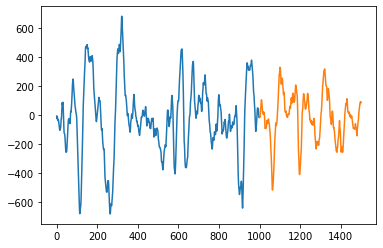

In [171]:
src, trg = ecog_multifile_dataset.__getitem__(-1)
plot_ch_idx = 10
plt.plot(np.arange(src_len),src[:,plot_ch_idx])
plt.plot(src_len+np.arange(trg_len),trg[:,plot_ch_idx])

holy shit - it works!